# Anomaly Detection in Bipartite Graphs - Model Comparison

This notebook compares different models for anomaly detection in bipartite graphs.

In [9]:
# Load the extension
%load_ext autoreload
# Configure it to reload all modules before each cell execution
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import sys
sys.path.append('..')

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import custom modules
from src.data.dataloader import load_member_features, load_provider_features, load_claims_data, prepare_hetero_data, inject_anomalies
from src.models.main_model import BipartiteGraphAutoEncoder
from src.models.baseline_models import MLPAutoencoder, SklearnBaseline, GCNAutoencoder, GATAutoencoder, SAGEAutoencoder
from src.utils.train_utils import train_model
from src.utils.eval_utils import evaluate_anomaly_detection, plot_precision_recall_curves, plot_anomaly_distribution, compare_models

## 1. Load and Prepare Data

In [4]:
df_member_features, members_dataset = load_member_features("../data/final_members_df.pickle")
df_provider_features, providers_dataset = load_provider_features("../data/final_df.pickle")
df_edges = load_claims_data("../data/df_descriptions.pickle", members_dataset=members_dataset, providers_dataset=providers_dataset)

print(f"Members: {len(members_dataset)}")
print(f"Providers: {len(providers_dataset)}")
print(f"Edges: {len(df_edges)}")

print("\nMember features:")
display(df_member_features.head())
print("\nProvider features:")
display(df_provider_features.head())
print("\nEdges:")
display(df_edges.head())

Members: 32560
Providers: 652
Edges: 58996

Member features:


,mean_claim_period,median_claim_period,min_claim_period,max_claim_period,std_claim_period,mean_claim_amount,median_claim_amount,min_claim_amount,max_claim_amount,std_claim_amount,...,avg_provider_claim_amount,unique_providers,num_claims,prop_claimtype_not_op,prop_claimtype_out-patient,single_interaction_ratio,gender_f,gender_m,principalcode_dependant,principalcode_principal
membercode,,,,,,,,,,,,,,,,,,,,,
589143,-0.304701,-0.212336,-0.315465,-0.051256,-0.674128,0.660569,0.483461,1.201042,0.967073,0.588056,...,0.320333,0.000000,1.906891,0.0,1.0,0.071429,1.0,0.0,0.0,1.0
589150,0.136534,0.267512,0.315465,0.337099,-0.044980,0.693704,0.060593,-0.461668,1.389210,0.919456,...,0.662848,2.089694,2.247928,0.0,1.0,0.111111,1.0,0.0,0.0,1.0
589151,0.000000,0.000000,0.000000,0.000000,0.000000,0.558524,0.686361,-0.390630,0.442232,0.667439,...,0.532630,0.000000,-0.415037,0.0,1.0,1.000000,0.0,1.0,1.0,0.0
589152,-0.665389,-0.362991,0.184535,-0.696713,-1.862060,0.008422,-0.130645,-0.502561,0.214536,0.247757,...,0.330445,0.000000,0.321928,0.0,1.0,0.250000,0.0,1.0,1.0,0.0
589154,1.468108,1.755317,2.210028,1.002648,0.000000,-0.022566,0.373619,0.292756,-0.233386,-0.145385,...,0.035693,0.000000,0.000000,0.0,1.0,0.333333,0.0,1.0,0.0,1.0



Provider features:


,one_hot_claim__finalstatus_infrequent_sklearn,one_hot_claim__claimtype_infrequent_sklearn,one_hot_claim__loastatus_infrequent_sklearn,one_hot_claim__roomtype_infrequent_sklearn,one_hot_claim__principalcode_principal,one_hot_claim__casetype_reimbursement,one_hot_claim__gender_m,one_hot_provider__providertype_clinic,one_hot_provider__providertype_hospital,one_hot_provider__providertype_infrequent_sklearn,...,std_member_claim_amount,mean_claim_amount,median_claim_amount,min_claim_amount,max_claim_amount,std_claim_amount,single_interaction_ratio,num_members,num_claims,hdbscan_cluster_from_semantics
providercode,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.062780,0.008969,0.0,0.349776,0.067265,0.399103,0.0,1.0,0.0,...,0.524022,0.321360,0.050260,-0.262126,0.966920,0.789321,-0.449752,0.563258,0.548708,1
17,0.0,0.000000,0.000000,0.0,0.472222,0.083333,0.333333,1.0,0.0,0.0,...,0.537356,0.474466,0.675916,0.763060,-0.215126,-0.003480,1.110301,-0.277891,-0.568451,1
53,0.0,0.008342,0.005214,0.0,0.662148,0.020855,0.344108,0.0,1.0,0.0,...,-0.393823,-0.617874,-0.583296,-0.231640,0.285726,-0.109757,-0.722677,1.375164,1.451557,1
54,0.0,0.007160,0.004773,0.0,0.625298,0.026253,0.436754,1.0,0.0,0.0,...,-0.328537,-0.548802,-0.583296,-0.440637,0.323048,-0.065129,-0.578037,0.911511,0.938692,1
76,0.0,0.175573,0.000000,0.0,0.694656,0.045802,0.580153,0.0,1.0,0.0,...,0.851399,1.081335,0.571845,0.456543,0.548513,0.721966,0.413834,0.404467,0.220617,1



Edges:


,provider_id,member_id,nbr_claims
3,4,589264,3
4,4,905121,1
6,4,905123,2
7,4,905144,2
8,4,905146,2


In [5]:
# Create HeteroData object
data = prepare_hetero_data(df_member_features, df_provider_features, df_edges)

print(data)
print(f"Member features shape: {data['member'].x.shape}")
print(f"Provider features shape: {data['provider'].x.shape}")
print(f"Number of edges: {data['provider', 'to', 'member'].edge_index.shape[1]}")

HeteroData(
  member={ x=[32560, 23] },
  provider={ x=[652, 38] },
  (provider, to, member)={
    edge_index=[2, 58996],
    edge_attr=[58996, 1],
  },
  (member, to, provider)={
    edge_index=[2, 58996],
    edge_attr=[58996, 1],
  }
)
Member features shape: torch.Size([32560, 23])
Provider features shape: torch.Size([652, 38])
Number of edges: 58996


## 2. Inject Synthetic Anomalies for Evaluation

In [6]:
np.random.seed(42)
torch.manual_seed(42)

# Inject anomalies
anomaly_percentage = 0.05  # 5% of nodes will be anomalies
anomaly_data, member_anomaly_labels, original_member_x = inject_anomalies(
    data, 'member', percentage=anomaly_percentage, scale=5.0
)

anomaly_data, provider_anomaly_labels, original_provider_x = inject_anomalies(
    anomaly_data, 'provider', percentage=anomaly_percentage, scale=5.0
)

print(f"Injected {member_anomaly_labels.sum().item()} member anomalies")
print(f"Injected {provider_anomaly_labels.sum().item()} provider anomalies")

Injected 1628 member anomalies
Injected 32 provider anomalies


## 3. Define Models to Compare

In [7]:
# Check if MPS is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Move data to device
anomaly_data = anomaly_data.to(device)
member_anomaly_labels = member_anomaly_labels.to(device)
provider_anomaly_labels = provider_anomaly_labels.to(device)

# Set dimensions based on data
in_dim_member = anomaly_data['member'].x.size(1)
in_dim_provider = anomaly_data['provider'].x.size(1)
max_dim = max(in_dim_member, in_dim_provider)
hidden_dim = 64
latent_dim = 32
edge_dim = 1  # For 'nbr_claims' as a scalar

# Define models to compare
models = {
    'MLP_Autoencoder': MLPAutoencoder(in_dim_member, in_dim_provider, hidden_dim, latent_dim).to(device),
    'Isolation_Forest': SklearnBaseline(method='iforest', n_estimators=100),
    'PCA': SklearnBaseline(method='pca', n_components=0.9),
    'GCN_Autoencoder': GCNAutoencoder(max_dim, hidden_dim, latent_dim).to(device),
    #'GAT_Autoencoder': GATAutoencoder(in_dim_member, in_dim_provider, hidden_dim, latent_dim).to(device),
    #'SAGE_Autoencoder': SAGEAutoencoder(max_dim, hidden_dim, latent_dim).to(device),
    'Bipartite_GAE': BipartiteGraphAutoEncoder(
        in_dim_member=in_dim_member,
        in_dim_provider=in_dim_provider,
        edge_dim=edge_dim,
        hidden_dim_member=hidden_dim,
        hidden_dim_provider=hidden_dim,
        out_dim=latent_dim,
        num_layers=2
    ).to(device)
}

Using device: mps


In [14]:
# Get feature dimensions from the data
in_dim_member = anomaly_data['member'].x.size(1)
in_dim_provider = anomaly_data['provider'].x.size(1)

# Initialize model with correct dimensions
model = GATAutoencoder(
    in_dim_member=in_dim_member,
    in_dim_provider=in_dim_provider,
    hidden_dim=64,
    latent_dim=32,
    heads=4,
    dropout=0.5
).to(device)

In [15]:
train_model(model, anomaly_data, num_epochs=2, plot=True)

: 

## 4. Train and Evaluate Models


--------------------------------------------------
Training and evaluating MLP_Autoencoder...
Epoch 001 | Train Loss: 3.0795 | Val Loss: 2.9327


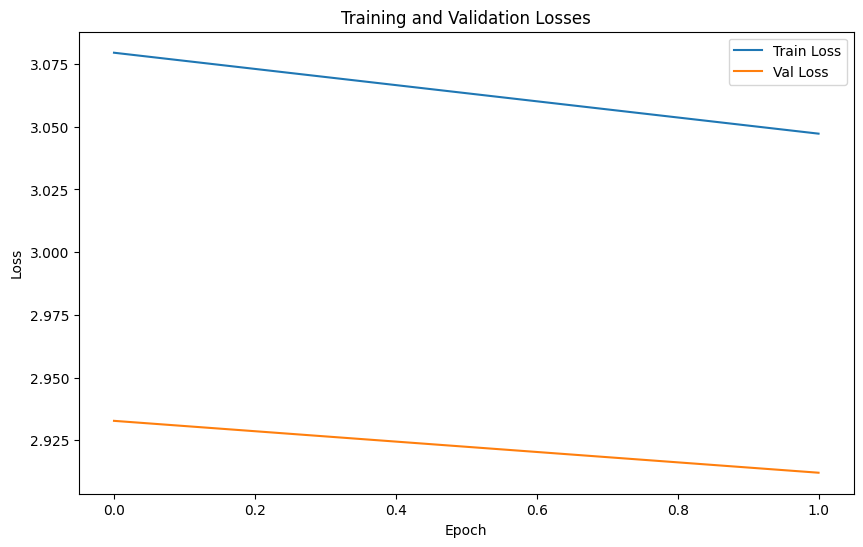


Results for MLP_Autoencoder:
  Member: AUC = 1.0000, AP = 0.9996
  Provider: AUC = 0.9995, AP = 0.9919

--------------------------------------------------
Training and evaluating Isolation_Forest...

Results for Isolation_Forest:
  Member: AUC = 1.0000, AP = 0.9999
  Provider: AUC = 0.9999, AP = 0.9981

--------------------------------------------------
Training and evaluating PCA...

Results for PCA:
  Member: AUC = 0.9981, AP = 0.9877
  Provider: AUC = 0.9902, AP = 0.8107

--------------------------------------------------
Training and evaluating GCN_Autoencoder...
Epoch 001 | Train Loss: 3.6142 | Val Loss: 3.0310


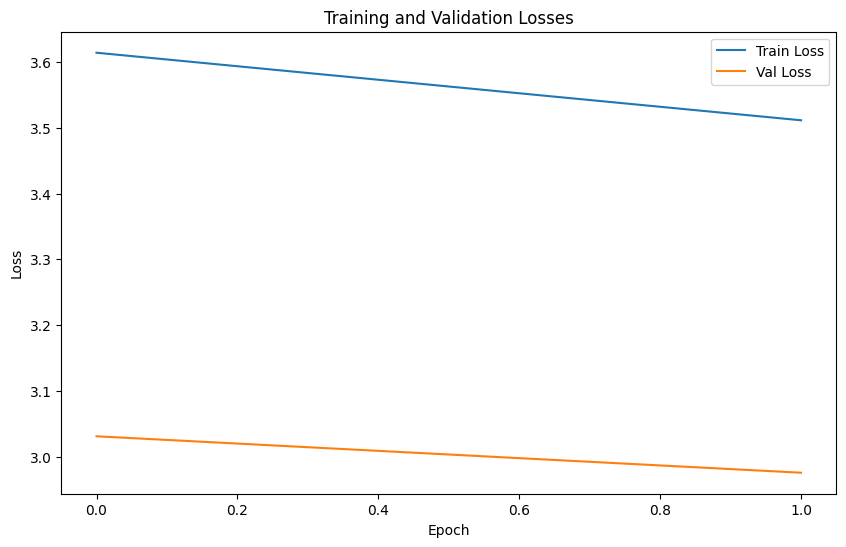


Results for GCN_Autoencoder:
  Member: AUC = 1.0000, AP = 0.9998
  Provider: AUC = 0.9997, AP = 0.9954

--------------------------------------------------
Training and evaluating Bipartite_GAE...
Epoch 001 | Train Loss: 3.2589 | Val Loss: 3.0322


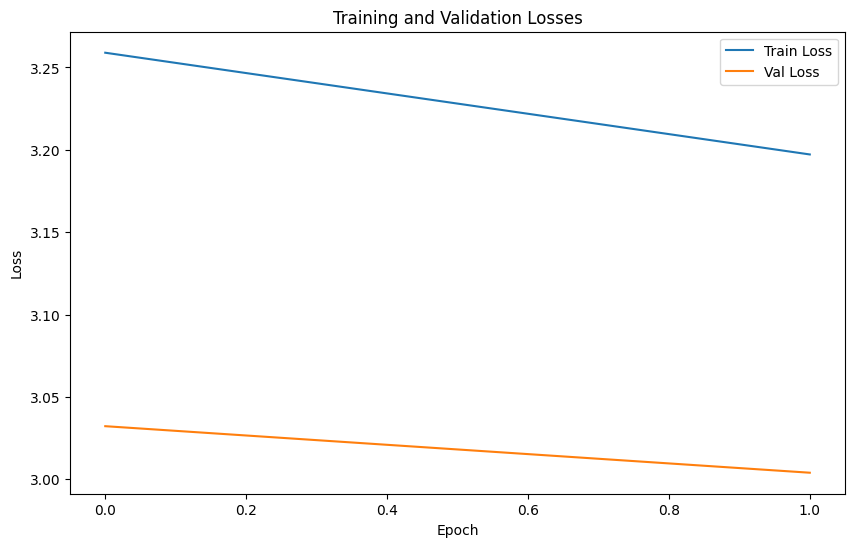


Results for Bipartite_GAE:
  Member: AUC = 1.0000, AP = 0.9997
  Provider: AUC = 0.9994, AP = 0.9904


In [11]:
all_results = {}
gt_labels = {
    'member': member_anomaly_labels,
    'provider': provider_anomaly_labels
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n{'-'*50}\nTraining and evaluating {name}...")
    
    if hasattr(model, 'fit'):  # For sklearn-based models
        model.fit(anomaly_data)
        results = evaluate_anomaly_detection(model, anomaly_data, gt_labels)
    else:  # For PyTorch models
        train_model(model, anomaly_data, num_epochs=2, plot=True)
        results = evaluate_anomaly_detection(model, anomaly_data, gt_labels)
    
    all_results[name] = results
    
    # Print quick summary
    print(f"\nResults for {name}:")
    for node_type in results:
        print(f"  {node_type.capitalize()}: AUC = {results[node_type]['auc']:.4f}, AP = {results[node_type]['ap']:.4f}")

## 5. Compare Results

In [ ]:
# Compare all models in a table
comparison_df = compare_models(all_results, list(models.keys()))
display(comparison_df)

In [ ]:
# Plot precision-recall curves for members
plot_precision_recall_curves(all_results, list(models.keys()), node_type='member')

# Plot precision-recall curves for providers
plot_precision_recall_curves(all_results, list(models.keys()), node_type='provider')

In [ ]:
# Plot anomaly score distributions
plot_anomaly_distribution(all_results, list(models.keys()), node_type='member')
plot_anomaly_distribution(all_results, list(models.keys()), node_type='provider')

## 6. Analysis and Conclusion

Based on the results above, we can draw the following conclusions:

1. **Performance Comparison**: [Your analysis based on the results]
2. **Strengths and Weaknesses**: [Discuss strengths/weaknesses of different models]
3. **Recommended Model**: [Which model performed best and why]
4. **Future Work**: [Suggestions for improvements]